In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import albumentations as A

import math
import random
import cv2
import numpy as np
import shutil
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow import keras

# 폐렴 Xray 이미지를 사용할 수 있게 처리하는 과정

In [49]:
# file_path1 = './data\\chest_xray\\train\\'
# file_names1 = os.listdir(file_path1)
# file_names1

# 주소 지정

In [50]:
# file_path2 = './data\\chest_xray\\val\\'
# file_names2 = os.listdir(file_path2)
# file_names2

In [51]:
# for name in file_names1:
#     j = 1
#     src = os.path.join(file_path1, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         dst = f'{name}_{j}.jpg'
#         os.rename(src + '\\' + name1, src + '\\' + dst)
#         j += 1

# 파일명 변경

In [52]:
# for name in file_names2:
#     j = 3876
#     src = os.path.join(file_path2, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         dst = f'{name}_{j}.jpg'
#         os.rename(src + '\\' + name1, src + '\\' + dst)
#         j += 1

# 데이터로더에 사용하기 위한 데이터프레임 생성

In [53]:
# df = pd.DataFrame(columns = ['name', 'pneumonia'])
# df

In [54]:
# i = 1
# for name in file_names1:
#     src = os.path.join(file_path1, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         elem = {
#             'name' : name1.split('.')[0],
#             'pneumonia' : i
#             }
#         df.loc[len(df)] = elem
#     i += 1
        
# df

# 데이터프레임 내용 생성

In [55]:
# i = 1
# for name in file_names2:
#     src = os.path.join(file_path2, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         elem = {
#             'name' : name1.split('.')[0],
#             'pneumonia' : i
#             }
#         df.loc[len(df)] = elem
#     i += 1
        
# df

# 사용하기 좋게 이미지들의 위치 정리

In [56]:
# for name in file_names1:
#     src = os.path.join(file_path1, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         shutil.move(src + '\\' + name1, './data\\chest_xray\\')

# for name in file_names2:
#     src = os.path.join(file_path2, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         shutil.move(src + '\\' + name1, './data\\chest_xray\\')

In [57]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import activations

In [58]:
# kf = KFold(n_splits=5, shuffle=True, random_state = 42)

# df['fold'] = -1
# for idx, (t,v) in enumerate(kf.split(df), 1):
#     print(t,v, len(v))
#     df.loc[v, 'fold'] = idx

# train와 valid를 구별하기 위한 fold값 설정 

In [59]:
# df.to_csv('./data/chest_xray.csv', index= False)

# 이미지 양을 늘리기 위한 Albumentation과 이미지 데이터로더

In [181]:
class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img


class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            name = r['name']
            
            image = cv2.imread(f'data/chest_xray/{name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image / 255.
            
            label = int(r['pneumonia']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [182]:
csv_path = 'data/chest_xray.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

# train, valid 이미지 데이터 로더 생성

# CNN 모델 생성 - 모델의 learning rate를 상당히 낮게 잡았다.

In [183]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [

            # input
            layers.Input(input_shape),

            # 1st
            layers.Conv2D(64, 3, strides=1, activation="relu", padding ='same'),
            layers.MaxPool2D(2, padding= 'same'),
            layers.BatchNormalization(),

            layers.Conv2D(64, 3, strides=1, activation="relu", padding ='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # 2nd
            layers.Conv2D(128, 3, strides=1, activation="relu", padding ='same'),
            layers.MaxPool2D(2, padding= 'same'),
            layers.BatchNormalization(),

            layers.Conv2D(128, 3, strides=1, activation="relu", padding ='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            # Classifier
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(1, activation='sigmoid')
        ]
    )

    return model

input_shape = (128,128,3)
model = get_sequential_model(input_shape)

model.summary()

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics='accuracy'
)
    

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                      

C:\Users\khj_a\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# 콜백 함수. 사실상 사용하는 것은 model_checkpoint뿐이다

In [184]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1,
    mode='min', restore_best_weights=False
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    mode='min', min_lr=0.001
)

filepath = '{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)

In [185]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[
        reduce_on_plateau,
        model_checkpoint
    ],
    verbose=1
)

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.4743 - accuracy: 0.7926
Epoch 00001: val_loss improved from inf to 0.60006, saving model to 01-0.60.hdf5
33/33 [==============================] - 180s 5s/step - loss: 0.4743 - accuracy: 0.7926 - val_loss: 0.6001 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.8989
Epoch 00002: val_loss improved from 0.60006 to 0.56365, saving model to 02-0.56.hdf5
33/33 [==============================] - 171s 5s/step - loss: 0.2393 - accuracy: 0.8989 - val_loss: 0.5636 - val_accuracy: 0.7230 - lr: 1.0000e-04
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.2092 - accuracy: 0.9166
Epoch 00003: val_loss did not improve from 0.56365
33/33 [==============================] - 179s 5s/step - loss: 0.2092 - accuracy: 0.9166 - val_loss: 0.5992 - val_accuracy: 0.8348 - lr: 1.0000e-04
Epoch 4/20
33/33 [==============================] - ETA: 0s 

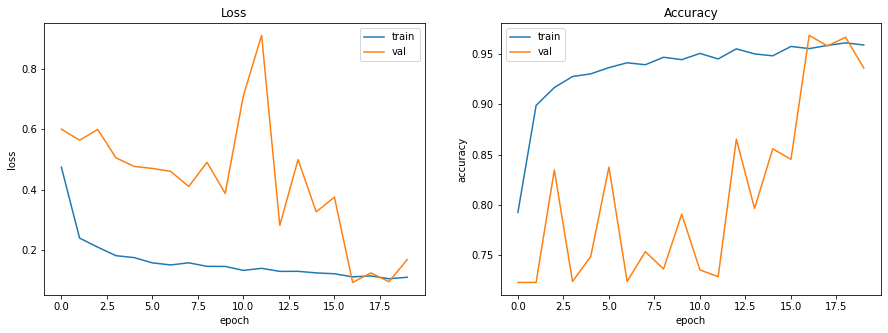

In [186]:
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.show()

# loss값과 accuracy값 시각화

# 테스트 이미지 데이터 정리 및 데이터 로더 생성

In [62]:
# file_path3 = './data\\chest_xray\\test\\'
# file_names3 = os.listdir(file_path3)
# file_names3

['NORMAL', 'PNEUMONIA']

In [67]:
# for name in file_names3:
#     j = 1
#     src = os.path.join(file_path3, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         dst = f'{name}_{j}.jpg'
#         os.rename(src + '\\' + name1, src + '\\' + dst)
#         j += 1

# for name in file_names3:
#     src = os.path.join(file_path3, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         shutil.move(src + '\\' + name1, './data\\chest_xray\\test\\')

In [187]:
class DataGenerator1(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
                
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            name = r['name']
            
            image = cv2.imread(f'data/chest_xray/test/{name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image.astype('uint8')
            
            image = image.astype('float32')
            image = image / 255.
            
            label = int(r['pneumonia']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [188]:
# df = pd.DataFrame(columns = ['name', 'pneumonia'])

# i = 1
# for name in file_names3:
#     src = os.path.join(file_path3, name)
#     src1 = os.listdir(src)
#     for name1 in src1:
#         elem = {
#             'name' : name1.split('.')[0],
#             'pneumonia' : i
#             }
#         df.loc[len(df)] = elem
#     i += 1
        
# df

In [189]:
# df.to_csv('./data/chest_xray_test.csv', index= False)

# 테스트 이미지 데이터 로더 생성. 나중에 이미지를 적절히 출력시키기 위해 batch_size를 이미지 데이터 전체값으로 줬다.

In [190]:
csv_path = 'data/chest_xray_test.csv'
test_generator = DataGenerator1(
    csv_path=csv_path,
    batch_size=624,
    image_size=128,
    shuffle=True)

In [191]:
score = model.evaluate(test_generator)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

# 테스트 데이터의 loss값과 정확도 측정.

1/1 [==============================] - 13s 13s/step - loss: 0.4466 - accuracy: 0.8253
Test Loss:  0.4465629458427429
Test Accuracy:  0.8253205418586731


# 테스트 이미지를 이용한 예측 결과 출력

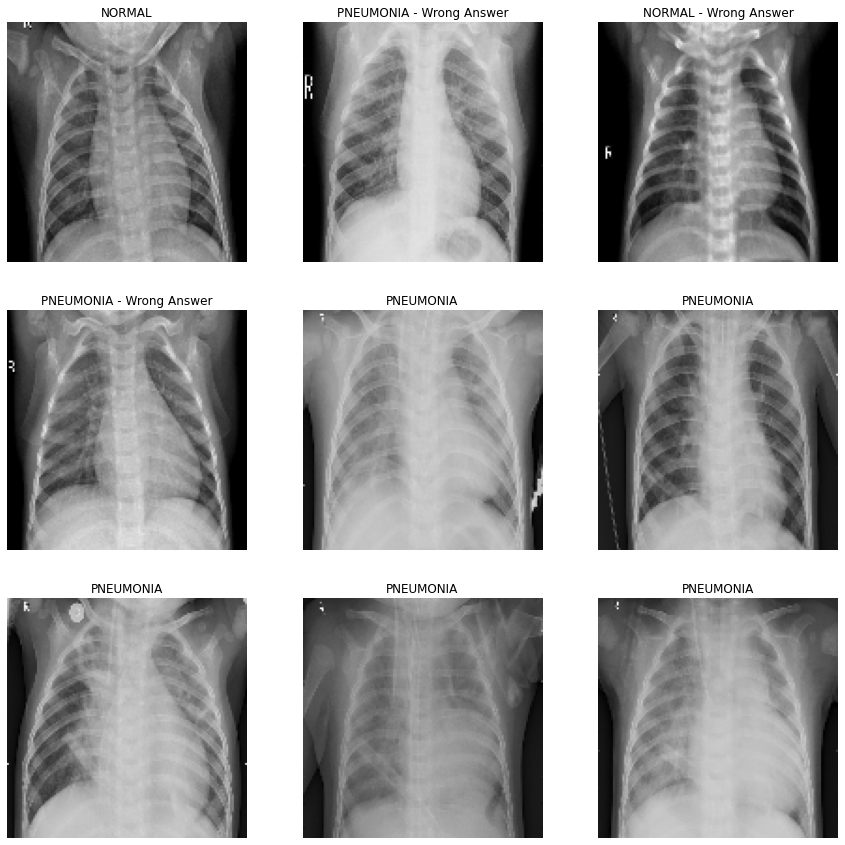

In [198]:
class_names = ['NORMAL', 'PNEUMONIA']
queue = []

for X,y in test_generator:              # X값이 테스트 이미지, y값이 그 이미지의 라벨이다
    pre = model.predict(X)              # 모델을 통한 테스트 이미지 예측
    pre = tf.where(pre < 0.5, 0, 1)     # 0이 나오면 정상, 1이 나오면 폐렴이다
    queue.append(pre)

    plt.figure(figsize=(15, 15))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        if int(queue[0][i]) == y[i]:                    # 예측과 실제값이 동일할시
            plt.title(class_names[int(queue[0][i])])
        else:                                           # 예측과 실제값이 다를시
            plt.title('{} - Wrong Answer'.format(class_names[int(queue[0][i])]))
        plt.axis('off')
    break